In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import datagen
from utils import datatreat
from utils import eigen_val
from utils import tau_GD
from utils import solve_ridge
from utils import GD
from utils import HB
from utils import GD_ncvx

In [2]:
np.random.seed(1)

In [3]:
A_,y_ = datagen()
n,p,n_train,n_test,A,y,A_test,y_test = datatreat(A_,y_,128)

Number of obs: 173
n train: 128
n test: 45
Number of explicative variables: 9


In [4]:
def mse(x,lbd): return 0.5*np.linalg.norm(A@x-y)**2/n_train+0.5*lbd*np.linalg.norm(x)**2

def dmse(x,lbd): return A.T@(A@x-y)/n_train+lbd*x

In [5]:
N_iter=1*10**2
lbd=0.05
x_0=np.zeros(p)

f = lambda x : mse(x,lbd)
df = lambda x : dmse(x,lbd)

x_star,f_star=solve_ridge(A,y,lbd)

In [6]:
mu,L=eigen_val(A,lbd)

tau_max,tau_opt=tau_GD(A,lbd)

tau_HB=1/np.sqrt(mu*L)

gamma_HB=( (np.sqrt(L)-np.sqrt(mu)) / (np.sqrt(L)+np.sqrt(mu)) )**2

print(mu,L)
print(mu/L)
print(np.sqrt(mu/L))
print(tau_HB,gamma_HB)

0.13760615060425516 5.165944727472905
0.0266371705203222
0.1632089780628572
1.1860587433495893 0.5175097456156991


In [7]:
xGD,fxGD=GD(tau_opt,x_0,f,df,N_iter)
f_errGD=np.abs(fxGD-f_star)

xHB,fxHB=HB(tau_HB,gamma_HB,x_0,f,df,N_iter)
f_errHB=np.abs(fxHB-f_star)

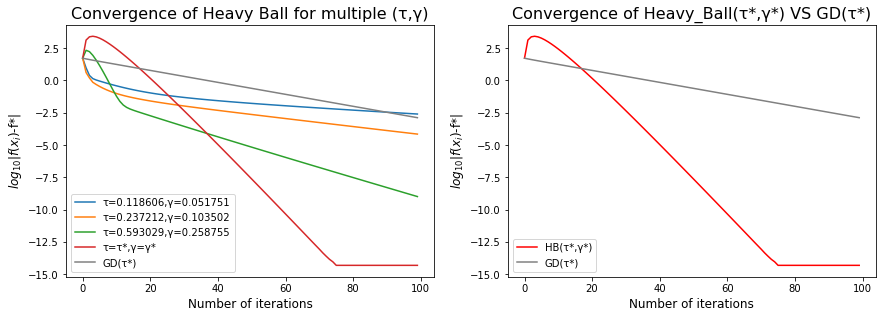

In [8]:
fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2)

tau=np.array([tau_HB/10,tau_HB/5,tau_HB/2])
gamma=np.array([gamma_HB/10,gamma_HB/5,gamma_HB/2])

for i in range(tau.size):
    trash,f_val=HB(tau[i],gamma[i],x_0,f,df,N_iter)
    f_err=np.abs(f_val-f_star)
    ax0.plot(np.log10(f_err), label="τ=%f"%tau[i]+",γ=%f"%gamma[i])

ax0.plot(np.log10(np.maximum(f_errHB,5e-15)),label="τ=τ*,γ=γ*")
ax0.plot(np.log10(f_errGD),label='GD(τ*)',color='grey')
ax0.set_xlabel("Number of iterations",fontsize=12)
ax0.set_ylabel("$log_{10}$|$f(x_i)$-f*|",fontsize=12)
ax0.legend(loc="lower left")
ax0.set_title("Convergence of Heavy Ball for multiple (τ,γ)", fontsize=16)


ax1.plot(np.log10(np.maximum(f_errHB,5e-15)),label='HB(τ*,γ*)',color='red')
ax1.plot(np.log10(f_errGD),label='GD(τ*)',color='grey')
ax1.set_xlabel("Number of iterations",fontsize=12)
ax1.set_ylabel("$log_{10}$|$f(x_i)$-f*|",fontsize=12)
ax1.legend(loc="lower left")
ax1.set_title("Convergence of Heavy_Ball(τ*,γ*) VS GD(τ*)", fontsize=16)


plt.subplots_adjust(left=None, bottom=None, right=2, top=1, wspace=None, hspace=None);

In [9]:
def mse_ncvx(x,lbd,alpha,d): 
    return 0.5*np.linalg.norm(A@x-y)**2/n_train+0.5*lbd*np.linalg.norm(x)**2+alpha*np.linalg.norm(x,d)**d/d

def mse_test(x): 
    return np.linalg.norm(A_test@x-y_test)**2/n_test

def dmse_ncvx(x,lbd,alpha,d): 
    return A.T@(A@x-y)/n_train+lbd*x+alpha*np.sign(x)*np.abs(x)**(d-1)

In [10]:
N_iter=120
x_0=np.ones(p)

lbd=0.05
d=0.5
alpha=0.25

f_ncvx = lambda x : mse_ncvx(x,lbd,alpha,d)
df_ncvx = lambda x : dmse_ncvx(x,lbd,alpha,d)

xGD_ncvx,fxGD_ncvx,xGD_ncvx_min,fxGD_ncvx_min=GD_ncvx(0.35,x_0,f_ncvx,df_ncvx,N_iter)

dfxGD_ncvx=np.zeros(N_iter)
dfxGD_ncvx_min=np.zeros(N_iter)


for i in range(N_iter):
    dfxGD_ncvx[i]=np.linalg.norm(df_ncvx(xGD_ncvx[i]))
    dfxGD_ncvx_min[i]=np.linalg.norm(df_ncvx(xGD_ncvx_min[i]))

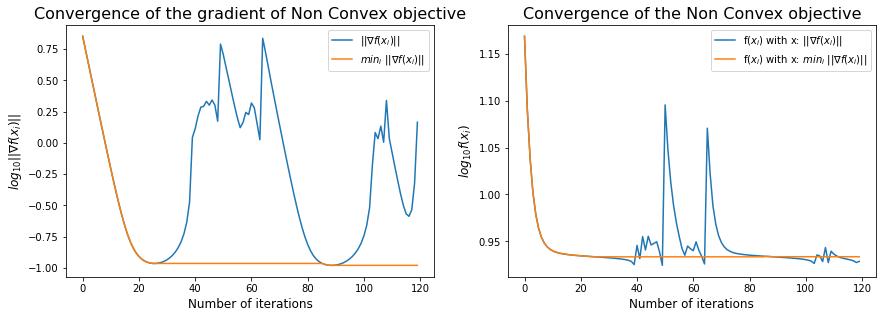

In [11]:
fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2)

ax0.plot(np.log10(dfxGD_ncvx),label='||$∇f(x_i)$||')
ax0.plot(np.log10(dfxGD_ncvx_min),label='$min_i$ ||$∇f(x_i)$||')
ax0.set_xlabel("Number of iterations",fontsize=12)
ax0.set_ylabel("$log_{10}$||$ ∇f(x_i)$||",fontsize=12)
ax0.set_title("Convergence of the gradient of Non Convex objective", fontsize=16)
ax0.legend()

ax1.plot(np.log10(fxGD_ncvx),label='f($x_i$) with x: ||$∇f(x_i)$||')
ax1.plot(np.log10(fxGD_ncvx_min),label='f($x_i$) with x: $min_i$ ||$∇f(x_i)$||')
ax1.set_xlabel("Number of iterations",fontsize=12)
ax1.set_ylabel("$log_{10}$$f(x_i)$",fontsize=12)
ax1.set_title("Convergence of the Non Convex objective", fontsize=16)
ax1.legend()

plt.subplots_adjust(left=None, bottom=None, right=2, top=1, wspace=None, hspace=None);

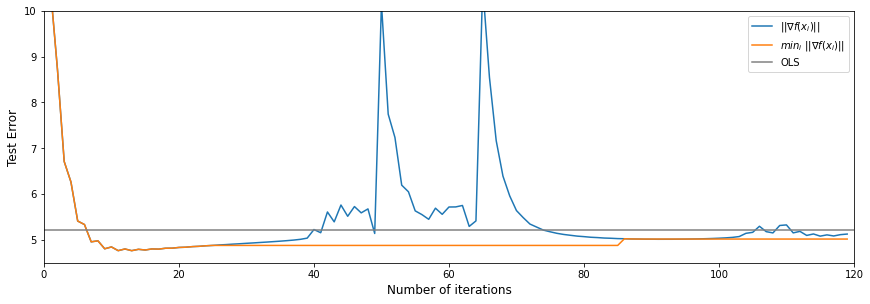

In [12]:
test_error_ncvx = np.zeros(N_iter)
test_error_ncvx_min = np.zeros(N_iter)
x_ols = np.linalg.inv(A.T@A)@A.T@y
test_error_OLS = mse_test(x_ols)

for i in range(N_iter):
    test_error_ncvx[i] = mse_test(xGD_ncvx[i])
    test_error_ncvx_min[i] = mse_test(xGD_ncvx_min[i])

plt.xlim(0,120)
plt.ylim(4.5,10)

plt.plot((test_error_ncvx),label='||$∇f(x_i)$||')
plt.plot((test_error_ncvx_min),label='$min_i$ ||$∇f(x_i)$||')
plt.axhline(y=test_error_OLS, label='OLS', color="grey")
plt.legend()

plt.xlabel("Number of iterations",fontsize=12)
plt.ylabel("Test Error",fontsize=12)

plt.subplots_adjust(left=None, bottom=None, right=2, top=1, wspace=None, hspace=None);